In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
from torchsummary import summary
from sklearn.metrics import confusion_matrix

from modules import EarlyStopping, TestResult

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
input_size = 224
size = (input_size, input_size)
normalize_mean = (0.4914, 0.4822, 0.4465)
normalize_std = (0.2470, 0.2435, 0.2616)
batch_size = 16
num_workers = 8

transform_train = transforms.Compose([
    transforms.Resize(size=size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize(normalize_mean, normalize_std)  
])
transform_validation = transforms.Compose([
    transforms.Resize(size=size),
    transforms.ToTensor(),
    # transforms.Normalize(normalize_mean, normalize_std)
])
transform_test = transforms.Compose([
    transforms.Resize(size=size),
    transforms.ToTensor(),
    # transforms.Normalize(normalize_mean, normalize_std)
])

train_dataset = torchvision.datasets.ImageFolder(
    '/home/opticho/source/SimCLR/datasets/dataset2(3)/train/train', 
    transform=transform_train
)
valid_dataset = torchvision.datasets.ImageFolder(
    '/home/opticho/source/SimCLR/datasets/dataset2(3)/train/valid', 
    transform=transform_validation
)
test_dataset = torchvision.datasets.ImageFolder(
    '/home/opticho/source/SimCLR/datasets/dataset2(3)/test', 
    transform=transform_test
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=num_workers,
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=num_workers,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

classes = ('COVID', 'Healthy', 'Other')

In [3]:
# 이미지를 보여주기 위한 헬퍼(helper) 함수
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    # img = img / 2 + 0.25     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

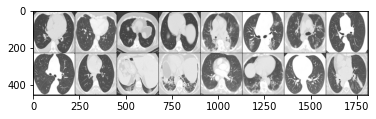

In [4]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

data_iter = iter(train_loader)
images, labels = data_iter.next()
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid)
writer.add_image('CT images', img_grid)

In [5]:
class Model(torch.nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.net = torch.hub.load('pytorch/vision:v0.6.0', 'densenet121', pretrained=True)
        self.net.classifier = torch.nn.Linear(1024, 3)

    def forward(self, x):
        x = self.net(x)
        return x

In [6]:
# net = Model()
net = torch.hub.load('pytorch/vision:v0.6.0', 'densenet121', pretrained=True)
net.classifier = torch.nn.Linear(1024, 3)
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-6, weight_decay=1e-1)

weights = [52, 18, 30]
class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)

# summary(net, (3, input_size, input_size))

Using cache found in /home/opticho/.cache/torch/hub/pytorch_vision_v0.6.0


In [7]:
writer.add_graph(net, images.to(device))
writer.close()

In [9]:
epochs = 100
patience = 5
save_path='./save'
early_stopping = EarlyStopping(
    patience=patience, 
    verbose=True, 
    save_path=save_path)

In [6]:
best_accuracy = 0.0
for epoch in range(epochs):
    train_accuracy, valid_accuracy = 0.0, 0.0
    train_loss, valid_loss = 0.0, 0.0
    
    # train
    net.train()
    losses = []
    correct, total = 0, 0
    for step, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels) # loss: tensor(loss, device, grad_fn)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        predicted = outputs.argmax(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_accuracy = correct / total * 100
    train_loss = np.average(losses)

    # validation
    net.eval()
    losses = []
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            losses.append(loss.item())
            predicted = outputs.argmax(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    valid_accuracy = correct / total * 100
    valid_loss = np.average(losses)

    print(f'[Epoch {epoch+1} / {epochs}]')
    print(f'Train - Loss: {train_loss:.6f}\tAccuracy: {train_accuracy:.2f}%')
    print(f'Valid - Loss: {valid_loss:.6f}\tAccuracy: {valid_accuracy:.2f}%')

    early_stopping(valid_loss, valid_accuracy, epoch, net, save=False)
    if early_stopping.early_stop:
        break


[Epoch 1 / 100]
Train - Loss: 1.243036	Accuracy: 23.16%
Valid - Loss: 1.210148	Accuracy: 27.70%
[Epoch 2 / 100]
Train - Loss: 1.146936	Accuracy: 32.24%
Valid - Loss: 1.119153	Accuracy: 34.81%
[Epoch 3 / 100]
Train - Loss: 1.059386	Accuracy: 41.62%
Valid - Loss: 1.030332	Accuracy: 44.89%
[Epoch 4 / 100]
Train - Loss: 0.990878	Accuracy: 50.92%
Valid - Loss: 0.979609	Accuracy: 50.67%
[Epoch 5 / 100]
Train - Loss: 0.932778	Accuracy: 56.69%
Valid - Loss: 0.932825	Accuracy: 56.30%
[Epoch 6 / 100]
Train - Loss: 0.880249	Accuracy: 60.37%
Valid - Loss: 0.875636	Accuracy: 58.81%
[Epoch 7 / 100]
Train - Loss: 0.827926	Accuracy: 62.13%
Valid - Loss: 0.818901	Accuracy: 60.15%
[Epoch 8 / 100]
Train - Loss: 0.787617	Accuracy: 64.12%
Valid - Loss: 0.827339	Accuracy: 61.33%
EarlyStopping counter: 1 out of 5
[Epoch 9 / 100]
Train - Loss: 0.749464	Accuracy: 65.88%
Valid - Loss: 0.781945	Accuracy: 61.78%
[Epoch 10 / 100]
Train - Loss: 0.718525	Accuracy: 66.91%
Valid - Loss: 0.752233	Accuracy: 60.89%
[Epoc

In [7]:
net.eval()
pred, true, soft = [], [], []
test_accuracy, test_loss = 0.0, 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # for majority voting
        softmax_fn = nn.Softmax(dim=1)
        softmax = softmax_fn(outputs).cpu().detach().tolist()
        for i in range(len(softmax)):
            soft.append(softmax[i])   

        predicted = outputs.argmax(1)

        pred_batch = predicted.cpu().numpy()
        true_batch = labels.cpu().numpy()
        for i in range(len(pred_batch)):
            pred.append(pred_batch[i].item())
            true.append(true_batch[i].item())


In [9]:
t = TestResult(pred, true, soft)
t.print_result()

Accuracy: 79.77 %

Confusion Matrix:
 [[360   8  34]
 [  5  86  42]
 [ 31  37 173]]

   class	sensitivity	specificity	support

   covid	0.90		0.90		402
 healthy	0.65		0.93		133
  others	0.72		0.86		241

   macro	0.75		0.90		776
weighted	0.80		0.89		776



In [22]:
import os
import csv

images_path = test_loader.dataset.samples
# images_path -> [ [images path, label] * 835 ]

with open(f"majority_denseNet.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerow(["file", "prob_0", "prob_1", "prob_2", "pred", "label", "result"])
    for i in range(len(pred)):
        f = os.path.basename(images_path[i][0])
        prob_0 = round(soft[i][0], 6)
        prob_1 = round(soft[i][1], 6)
        prob_2 = round(soft[i][2], 6)
        predict = pred[i]
        label = true[i]
        res = 0
        if predict == label:
            res = 1
        wr.writerow([f, prob_0, prob_1, prob_2, predict, label, res])    